In [9]:
import pandas as pd 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation

In [10]:
sao_goncalo_data = pd.read_csv("data/data.csv")

sao_goncalo_data = sao_goncalo_data[sao_goncalo_data['Rio'] != 'lagoa dos patos']

sao_goncalo_data['ds'] = pd.to_datetime(sao_goncalo_data['ds'])

sao_goncalo_data['ds'] = sao_goncalo_data['ds'].dt.strftime('%d-%m-%Y, %H:%M:%S')

In [11]:
sao_goncalo_data.head()

,ds,Rio,y
1,"05-04-2024, 14:00:00",sao goncalo,1.94
3,"05-04-2024, 20:00:00",sao goncalo,1.88
5,"05-05-2024, 15:00:00",sao goncalo,2.02
7,"05-05-2024, 20:00:00",sao goncalo,2.03
9,"05-06-2024, 09:00:00",sao goncalo,2.08


In [12]:
pos_wind = pd.read_csv("data/wind.csv")

pos_wind['ds'] = pd.to_datetime(pos_wind['ds'])

pos_wind['ds'] = pos_wind['ds'].dt.strftime('%d-%m-%Y, %H:%M:%S')

sao_goncalo_data = pd.merge(sao_goncalo_data, pos_wind, on="ds")

In [14]:
pos_wind

,ds,pos_wind
0,"05-04-2024, 14:00:00",126
1,"05-04-2024, 20:00:00",82
2,"05-05-2024, 15:00:00",112
3,"05-05-2024, 20:00:00",82
4,"05-06-2024, 09:00:00",45
...,...,...
61,"05-11-2024, 20:00:00",130
62,"05-11-2024, 21:00:00",130
63,"05-11-2024, 22:00:00",120
64,"05-11-2024, 23:00:00",120


08:11:16 - cmdstanpy - INFO - Chain [1] start processing
08:11:16 - cmdstanpy - INFO - Chain [1] done processing


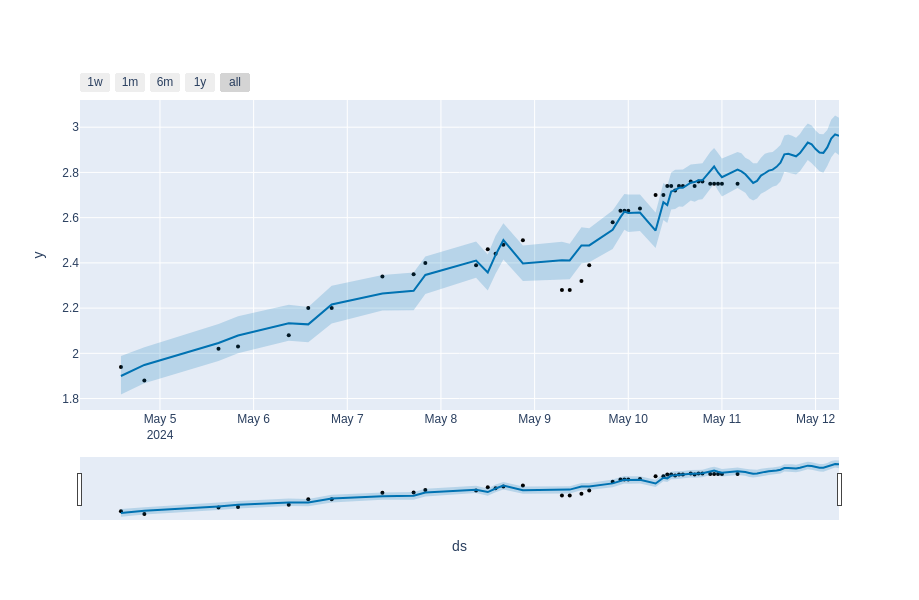

In [28]:
m = Prophet(
    yearly_seasonality=False,  
    weekly_seasonality=False,  
    daily_seasonality=True,    
    changepoint_range=0.8,     
    changepoint_prior_scale=0.8,
    changepoints=['2024-05-09 04:00:00'],
    growth="linear"         
)

# Defina os pontos de mudança
m.add_seasonality(name='daily', period=1, fourier_order=1, prior_scale = 0.01)
m.add_regressor("pos_wind", mode = "multiplicative", prior_scale = 0.8)

# Ajuste o modelo
m.fit(sao_goncalo_data)

# Realize previsões
future = m.make_future_dataframe(periods=26, freq='h')  

future['pos_wind'] = pos_wind['pos_wind']

forecast = m.predict(future)

# Visualize o resultado do modelo
plot_plotly(m, forecast)

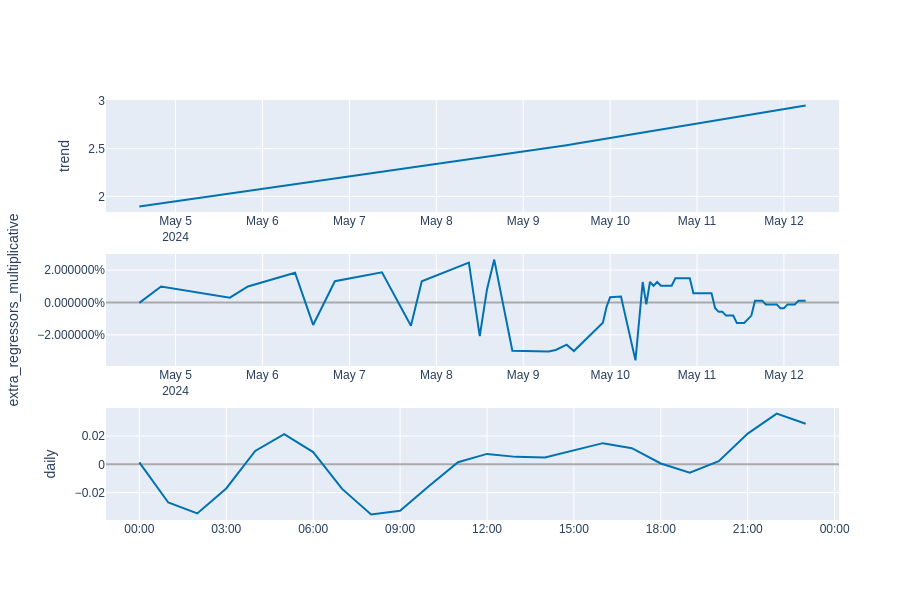

In [29]:
plot_components_plotly(m, forecast)

In [30]:
df_cv = cross_validation(m, initial='2 days', period='12 days', horizon = '3 days')
df_cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

08:11:55 - cmdstanpy - INFO - Chain [1] start processing
08:11:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-05-08 09:00:00,2.650670,2.643594,2.657520,2.39,2024-05-08 04:00:00
1,2024-05-08 12:00:00,0.361743,0.354900,0.368045,2.46,2024-05-08 04:00:00
2,2024-05-08 14:00:00,2.326017,2.319588,2.333250,2.44,2024-05-08 04:00:00
3,2024-05-08 16:00:00,2.455769,2.448996,2.462270,2.48,2024-05-08 04:00:00
4,2024-05-08 21:00:00,-0.552007,-0.559036,-0.544949,2.50,2024-05-08 04:00:00


In [31]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 10:00:00,1.494541,1.222514,0.824303,0.336244,0.109067,0.546155,0.0
1,0 days 12:00:00,1.472087,1.213296,0.745490,0.303145,0.046714,0.514952,0.0
2,0 days 17:00:00,3.109442,1.763361,1.063407,0.425763,0.046714,0.685883,0.0
3,1 days 03:00:00,4.976967,2.230912,1.815319,0.756641,1.039350,1.336606,0.0
4,1 days 05:00:00,5.015204,2.239465,1.920427,0.803027,1.039350,1.386970,0.0


/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



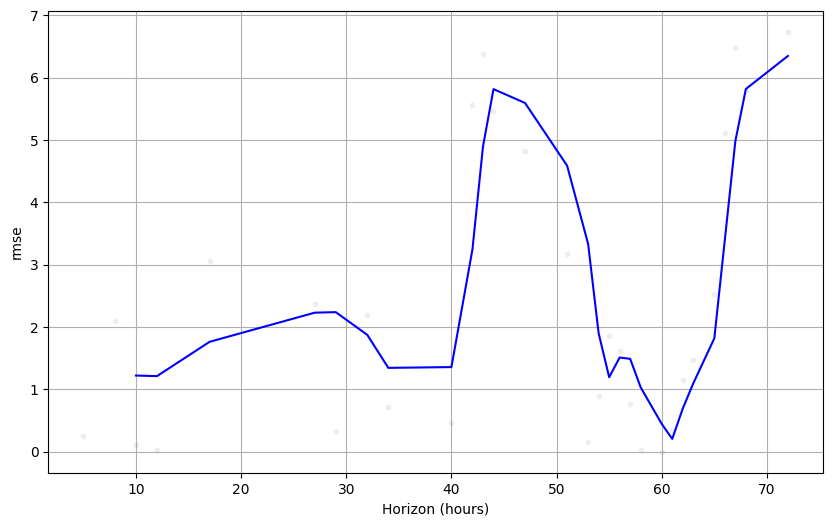

In [32]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [14]:
with open('data/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))